# CSCE 479/879 Hackathon: Convolutional and Pooling Layers

Written by Eleanor Quint

Modified by Mrinal Rawool and Stephen Scott

Topics: 
- Convolutional layers
- Pooling layers

This is all setup in a IPython notebook so you can run any code you want to experiment with. Feel free to edit any cell, or add some to run your own code.

In [1]:
# We'll start with our library imports...
from __future__ import print_function

import numpy as np                 # to use numpy arrays
import tensorflow as tf            # to specify and run computation graphs
import tensorflow_datasets as tfds # to load training data
import matplotlib.pyplot as plt    # to visualize data and draw plots
from tqdm import tqdm              # to track progress of loops

DATA_DIR = './tensorflow-datasets/'

In this hackathon, we'll be using convolutional layers, which are uniquely suited to working with image data. We'll use a dataset which is much more challenging if you're only using dense layers, [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html).

In [2]:
ds = tfds.load('cifar10', shuffle_files=True, data_dir=DATA_DIR) # this loads a dict with the datasets

# We can create an iterator from each dataset
# This one iterates through the train data, shuffling and minibatching by 32
train_ds = ds['train'].shuffle(1024).batch(32)

2024-02-26 12:39:17.938883: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

2024-02-26 12:39:26.032070: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :
2024-02-26 12:39:26.032096: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-02-26 12:39:26.032108: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c1217.swan.hcc.unl.edu): /proc/driver/nvidia/version does not exist
2024-02-26 12:39:26.043102: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to ./tensorflow-datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


You might see warnings when you run the below cell for the first time. If you run it again, the warning goes away. So you can safely ignore the warning.

In [5]:
ds = tfds.load('cifar10', shuffle_files=True, data_dir=DATA_DIR) # this loads a dict with the datasets

# We can create an iterator from each dataset
# This one iterates through the train data, shuffling and minibatching by 32
train_ds = ds['train'].shuffle(1024).batch(32)

In [6]:
# Looping through the iterator, each batch is a dict
for batch in train_ds:
    print("data shape:", batch['image'].shape)
    print("label:", batch['label'])
    break

data shape: (32, 32, 32, 3)
label: tf.Tensor([7 8 8 5 7 8 7 6 7 5 5 7 3 7 5 5 2 9 9 7 1 7 0 9 9 1 5 9 5 1 6 8], shape=(32,), dtype=int64)


2024-02-26 12:41:49.832490: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


An image looks like this:


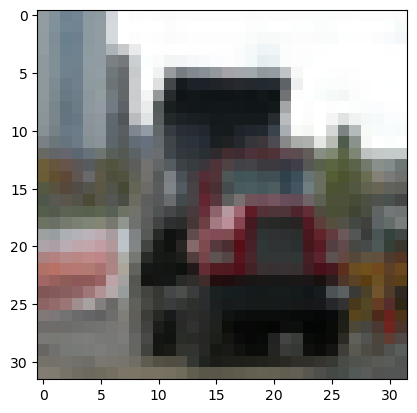

In [8]:
# visualize some of the data, pick randomly every time this cell is run
idx = np.random.randint(batch['image'].shape[0])
print("An image looks like this:")
imgplot = plt.imshow(batch['image'][idx])

## Convolutional Layers

TensorFlow implements the convolutional layer with [`tf.keras.layers.Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D). The function that instantiates the layer has two required arguments: number of filters and filter size. The number of filters will be equal to the number of channels in the output.

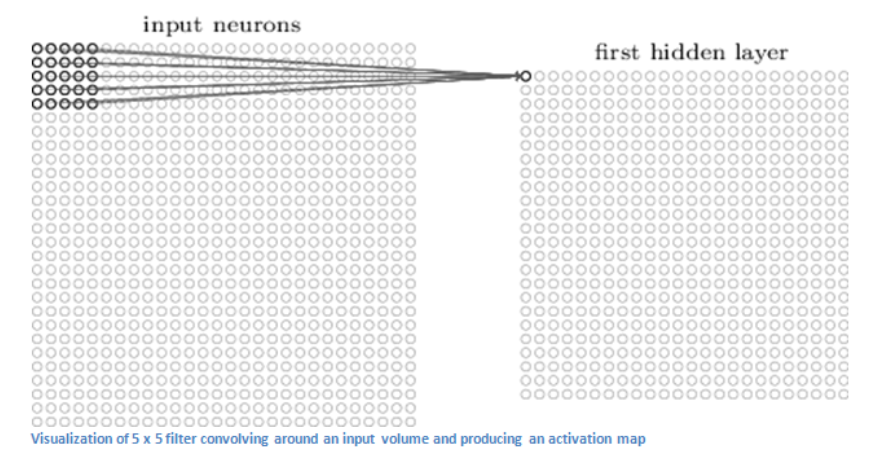

Important to keep in mind is:

1. Input data should be 4-dimensional with shape (batch, height, width, channels), unless the data_format argument is specified.
2. Padding is `'valid'` by default, meaning that only filters which lie fully within the input image will be kept. This will make the resulting image slightly smaller than the input. Use `padding='same'` if image size should be preserved.
3. Specifying `strides=n` for some n > 1 will result in an output image multiplicatively smaller than the input by a factor of n. Make sure that n isn't greater than the filter size unless you intend to completely ignore part of the input.

Let's specify a convolutional classifier.

In [9]:
# hidden_1 produces 32 feature maps
hidden_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation=tf.nn.relu, name='hidden_1')
# hidden_1 produces 64 feature maps
hidden_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation=tf.nn.relu, name='hidden_2')
# before sending feature maps to the dense layer, we need to flatten them
flatten = tf.keras.layers.Flatten()
# Dense layers have 10 units because we have 10 classes
output = tf.keras.layers.Dense(10)
conv_classifier = tf.keras.Sequential([hidden_1, hidden_2, flatten, output])

This architecture of a convolutional stack followed by dense layers for classification is pretty typical. It has the major advantages of making spacially local transformations to the image, followed by a global transformation which makes the final classification decision. You might notice as well that the number of filters goes up after each convolution. This is to allow higher layers to learn more specific patterns, so we require more of them than the general patterns of the earlier layers.

The number of parameters in each convolution layer can be calculated as `filter_height * filter_width * in_channels * output_channels`, as opposed to dense layers which have `input_size * output_size` parameters. For example, if we're working with CIFAR images, a first layer 3x3 convolution with 32 filters will have `3 * 3 * 3 * 32 = 864` parameters, compared to a dense layer with 32 neurons' `(32 * 32 * 3) * 32 = 98304` parameters. This is a factor of ~114 decrease, significantly smaller!

We can use a function of `tf.keras.Sequential` to see more information about the network, but only after the model has been built.

In [12]:
# Run some data through the network to initialize it
for batch in train_ds:
    # data is uint8 by default, so we have to cast it
    conv_classifier(tf.cast(batch['image'], tf.float32))
    break
conv_classifier.summary()
# output shape: (batch, height, width, channels)
# 32 x 32 x 64 = 65536

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Conv2D)            (32, 32, 32, 32)          896       
_________________________________________________________________
hidden_2 (Conv2D)            (32, 32, 32, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (32, 65536)               0         
_________________________________________________________________
dense (Dense)                (32, 10)                  655370    
Total params: 674,762
Trainable params: 674,762
Non-trainable params: 0
_________________________________________________________________


2024-02-26 13:10:38.331726: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Notice that the number of channels in each output shape is equal to the number of filters in the channel. Notice also that the Flatten layer changes the shape of the data to only having two dimensions, this allows us to feed it to the Dense layer in the usual way.

Let's re-create the network which we used to classify MNIST from Hackathon 2.

In [11]:
# Create the model
# We need flatten() before the first dense layer
dense_classifier = tf.keras.Sequential([tf.keras.layers.Flatten(), 
                                        tf.keras.layers.Dense(200), 
                                        tf.keras.layers.Dense(10)])

# Initialize the model
for batch in train_ds:
    # data is uint8 by default, so we have to cast it
    dense_classifier(tf.cast(batch['image'], tf.float32))
    break

dense_classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (32, 3072)                0         
_________________________________________________________________
dense_1 (Dense)              (32, 200)                 614600    
_________________________________________________________________
dense_2 (Dense)              (32, 10)                  2010      
Total params: 616,610
Trainable params: 616,610
Non-trainable params: 0
_________________________________________________________________


2024-02-26 13:01:21.994087: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Why do we need pooling layers?

This densely connected network has fewer parameters than the convolutional network! If we compare them, the one dense layer in the convolutional network has more paramters than the entire dense network. This is because **the representation grows as it passes through the conv network**, which is undesirable. **We can handle this by summarizing the data with pooling layers**. We'll add **max pool layers** which act similarly to conv layers, but rather than computing a function with a filter, **it selects the pixel with the highest value in the window** and ignores the rest.

Let's respecify a larger conv network than the above, but this time with max pooling layers:

Input -> Conv2D -> Conv2D -> Pool -> Conv2D -> Conv2D -> Pool -> Flatten -> Dense

In [21]:
hidden_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation=tf.nn.relu, name='hidden_1')
hidden_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation=tf.nn.relu, name='hidden_2')
pool_1 = tf.keras.layers.MaxPool2D(padding='same')
hidden_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu, name='hidden_3')
hidden_4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation=tf.nn.relu, name='hidden_4')
pool_2 = tf.keras.layers.MaxPool2D(padding='same')
flatten = tf.keras.layers.Flatten()
output = tf.keras.layers.Dense(10)
conv_classifier = tf.keras.Sequential([hidden_1, hidden_2, pool_1, hidden_3, hidden_4, pool_2, flatten, output])
# HINT: while training, you can use sparse_categorical_crossentropy loss 
# HINT: dense layer needs softmax activation for multi-class classification

# Run some data through the network to initialize it
for batch in train_ds:
    # data is uint8 by default, so we have to cast it
    conv_classifier(tf.cast(batch['image'], tf.float32))
    break
conv_classifier.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Conv2D)            (32, 32, 32, 32)          896       
_________________________________________________________________
hidden_2 (Conv2D)            (32, 32, 32, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 16, 16, 64)          0         
_________________________________________________________________
hidden_3 (Conv2D)            (32, 16, 16, 128)         73856     
_________________________________________________________________
hidden_4 (Conv2D)            (32, 16, 16, 256)         295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (32, 8, 8, 256)           0         
_________________________________________________________________
flatten_6 (Flatten)          (32, 16384)              

2024-02-26 14:22:39.524232: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Effect of stride

In [13]:
# hidden_1 produces 32 feature maps
hidden_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', strides=(1, 1), activation=tf.nn.relu, name='hidden_1')
# hidden_1 produces 64 feature maps
hidden_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', strides=(1, 1), activation=tf.nn.relu, name='hidden_2')
# before sending feature maps to the dense layer, we need to flatten them
flatten = tf.keras.layers.Flatten()
# Dense layers have 10 units because we have 10 classes
output = tf.keras.layers.Dense(10)
conv_classifier = tf.keras.Sequential([hidden_1, hidden_2, flatten, output])

# Run some data through the network to initialize it
for batch in train_ds:
    # data is uint8 by default, so we have to cast it
    conv_classifier(tf.cast(batch['image'], tf.float32))
    break
conv_classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Conv2D)            (32, 32, 32, 32)          896       
_________________________________________________________________
hidden_2 (Conv2D)            (32, 32, 32, 64)          18496     
_________________________________________________________________
flatten_2 (Flatten)          (32, 65536)               0         
_________________________________________________________________
dense_3 (Dense)              (32, 10)                  655370    
Total params: 674,762
Trainable params: 674,762
Non-trainable params: 0
_________________________________________________________________


2024-02-26 13:15:14.995549: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [14]:
# hidden_1 produces 32 feature maps
hidden_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', strides=(2, 1), activation=tf.nn.relu, name='hidden_1')
# hidden_1 produces 64 feature maps
hidden_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', strides=(2, 1), activation=tf.nn.relu, name='hidden_2')
# before sending feature maps to the dense layer, we need to flatten them
flatten = tf.keras.layers.Flatten()
# Dense layers have 10 units because we have 10 classes
output = tf.keras.layers.Dense(10)
conv_classifier = tf.keras.Sequential([hidden_1, hidden_2, flatten, output])

# Run some data through the network to initialize it
for batch in train_ds:
    # data is uint8 by default, so we have to cast it
    conv_classifier(tf.cast(batch['image'], tf.float32))
    break
conv_classifier.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Conv2D)            (32, 16, 32, 32)          896       
_________________________________________________________________
hidden_2 (Conv2D)            (32, 8, 32, 64)           18496     
_________________________________________________________________
flatten_3 (Flatten)          (32, 16384)               0         
_________________________________________________________________
dense_4 (Dense)              (32, 10)                  163850    
Total params: 183,242
Trainable params: 183,242
Non-trainable params: 0
_________________________________________________________________


2024-02-26 13:15:19.740103: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [15]:
# hidden_1 produces 32 feature maps
hidden_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', strides=(2, 2), activation=tf.nn.relu, name='hidden_1')
# hidden_1 produces 64 feature maps
hidden_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', strides=(2, 2), activation=tf.nn.relu, name='hidden_2')
# before sending feature maps to the dense layer, we need to flatten them
flatten = tf.keras.layers.Flatten()
# Dense layers have 10 units because we have 10 classes
output = tf.keras.layers.Dense(10)
conv_classifier = tf.keras.Sequential([hidden_1, hidden_2, flatten, output])

# Run some data through the network to initialize it
for batch in train_ds:
    # data is uint8 by default, so we have to cast it
    conv_classifier(tf.cast(batch['image'], tf.float32))
    break
conv_classifier.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Conv2D)            (32, 16, 16, 32)          896       
_________________________________________________________________
hidden_2 (Conv2D)            (32, 8, 8, 64)            18496     
_________________________________________________________________
flatten_4 (Flatten)          (32, 4096)                0         
_________________________________________________________________
dense_5 (Dense)              (32, 10)                  40970     
Total params: 60,362
Trainable params: 60,362
Non-trainable params: 0
_________________________________________________________________


2024-02-26 13:15:49.220885: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


With pooling we've created a much bigger network with fewer parameters. Another way to reduce the size of the data is by setting the `stride` parameter of conv layers to be greater than one (typically two). This will have a similar effect to pooling in reducing the size of the representation by a factor of 4.

### What does a confusion matrix look like?

[Additional resource on confusion matrix](https://towardsai.net/p/l/multi-class-model-evaluation-with-confusion-matrix-and-classification-report)

Sample code from [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)

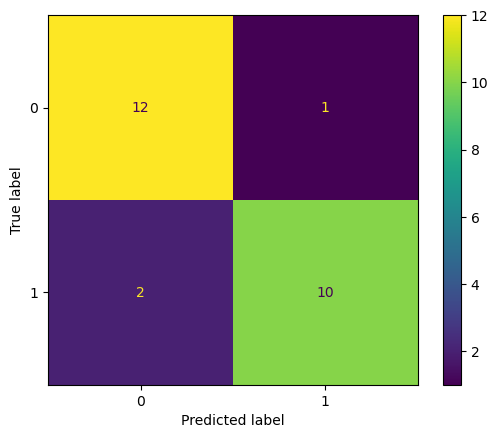

In [22]:

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=0)
clf = SVC(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
   y_test, y_pred)
plt.show()

### Homework

Re-write your code from hackathon 2 to use convolutional layers and add code to plot a confusion matrix on the validation data.

- to specify a network with tf.keras.layers.Conv2D (**remember, the last layer will be Dense with units = number of classes**)
- train it on the MNIST dataset with train split
- write code to calculate a confusion matrix of the model output on the validation data, and compare to the true labels to calculate a confusion matrix with [tf.math.confusion_matrix](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix). (For the inexperienced, [what is a confusion matrix?](https://en.wikipedia.org/wiki/Confusion_matrix)) Use the code example from [scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html) to help visualise the confusion matrix if you'd like as well.


On Canvas, submit your python code in a `.py` and your confusion matrix in a `.png`.

I'm expecting this to take about an hour (or less if you're experienced). Feel free to use any code from this or previous hackathons. If you don't understand how to do any part of this or if it's taking you longer than that, please let me know in office hours or by email (both can be found on the syllabus). I'm also happy to discuss if you just want to ask more questions about anything in this notebook!

### Coda

#### Convolutional Filters from the First Layer of ImageNet

Interestingly, automatically learned filters often closely resemble [Gabor Filters](https://en.wikipedia.org/wiki/Gabor_filter). The first layer of the original ImageNet network learned the following filters:

![](http://smerity.com/media/images/articles/2016/imagenet_conv_kernels.png "Convolutional Filters from the First Layer of ImageNet")

#### [Visualizing Convolutional Features](https://distill.pub/2017/feature-visualization/)